<a href="https://colab.research.google.com/github/jeric250/Data-Science-Projects/blob/main/Word_Embedding_using_DistilBERT_vs_TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classify Sentiment of Movie Review
Using movie review data from Stanford Sentiment Treebank v2 ([SST2](https://nlp.stanford.edu/sentiment/index.html)), the goal is to classfy the sentiment of the movie review as positive or negative.

As movie reviews are text, there is a need to preprocess and encode the text before passing the data to a classifer. 2 methods will be used: 
* Pass text data to a pre-trained DistBERT model to obtain embedding
* Pass text data to a TF-IDF vectorization to obtain encoding

Once the embeddings are obtained for the text data, a logistic regression model will take in the embeddings and classfiy the review/sentence as either positive or negative. The performance of using text embeddings from DistilBERT and TF-IDF will then be compared. While TF-IDF is known to be relatively robust, DistilBERT is expected to offer richer embeddings that would be useful for classification. The null hypothesis is that a classifier using embeddings from DistilBERT will have better performance compared to embeddings from TF-IDF.

This is partly inspired by Jay Alammar's [blog](http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/) on BERT. 

## 1. Load Libraries and Dataset

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 82.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import torch
import transformers as ppb
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
# obtain movie review dataset, with each review labeled as positive (1) or negative (0)
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [ ]:
list(df[0].head()) # movie review sentences has punctuation and stopwords

['a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films',
 'apparently reassembled from the cutting room floor of any given daytime soap',
 "they presume their audience wo n't sit still for a sociology lesson , however entertainingly presented , so they trot out the conventional science fiction elements of bug eyed monsters and futuristic women in skimpy clothes",
 'this is a visually stunning rumination on love , memory , history and the war between art and commerce',
 "jonathan parker 's bartleby should have been the be all end all of the modern office anomie films"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       6920 non-null   object
 1   1       6920 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [ ]:
df[1].value_counts(normalize=True)

1    0.521676
0    0.478324
Name: 1, dtype: float64

## 2. Text Sentiment Classification Using Embedding from DistilBERT

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased') # not case sensitive

## For BERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# define custom function to obtain embedding for text sentences using DistilBERT
# based on: http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
def get_sentence_embedding(df, sentence_col_name, n_batch=5):
    global tokenizer, model
    
    # initialize empty array with 768 dim: https://stackoverflow.com/questions/22392497/how-to-add-a-new-row-to-an-empty-numpy-array
    sentence_embedding = np.empty((0,768)) # default dtype=float
    
    # tokenize each sentence: break sentences into words/tokens suitable for BERT
    tokenized = df[sentence_col_name].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # find max len among tokenized sentences (for padding)
    max_len = max(map(len, tokenized.values)) # apply len function on each i in tokenized.values (i = tokenized sentence)

    # break data into batches as input into BERT to ease memory requirements
    for chunk in np.array_split(df, n_batch):
        # pad each tokenized sentence: fix len equal to max sentence len (pad shorter rows with zeros)
        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized[chunk.index].values])
        
        # create variable to tell BERT to ignore (mask) the padding added when it's processing its input
        attention_mask = np.where(padded != 0, 1, 0)

        # run sentence through model (BERT)
        input_ids = torch.tensor(padded)  
        attention_mask = torch.tensor(attention_mask)

        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)

        # only include BERT output corresponding to the first token ([CLS] token) of each sentence
        embedding_batch = last_hidden_states[0][:,0,:].numpy()
        sentence_embedding = np.append(sentence_embedding, embedding_batch, axis=0) # append by rows

    return sentence_embedding

In [ ]:
df1 = df.copy()
df1.rename({0: 'review', 1: 'class'}, axis=1, inplace=True) # axis='columns' also works
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  6920 non-null   object
 1   class   6920 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.2+ KB


In [ ]:
df1.head()

,review,class
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [ ]:
# obtain embedding for sentence
review_emb = get_sentence_embedding(df1, 'review', n_batch=14) # each batch is size of 500 rows, except for last batch which has size of 420

In [ ]:
labels = df1['class']
labels.shape

(6920,)

In [ ]:
# train, test split data
X_train, X_test, y_train, y_test = train_test_split(review_emb, labels, test_size=0.33, stratify=labels, random_state=2405)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4636, 768) (4636,)
(2284, 768) (2284,)


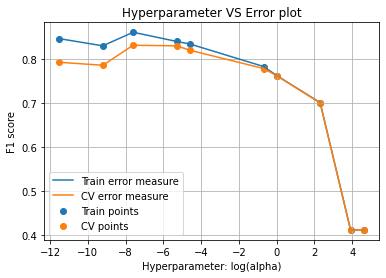

Best F1 score: 0.831
Best parameters:  {'alpha': 0.0005}
Best parameters (log transformed): -7.601


In [ ]:
# logistic regression hyperparameter tuning
log_reg = SGDClassifier(loss='log')
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(log_reg, parameters, scoring='f1', return_train_score=True, random_state=1989, error_score="raise") # default cv is 5, default n_iter is 10
clf.fit(X_train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])
train_score = results['mean_train_score']
train_score_std = results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_score, label='Train error measure')
plt.plot(np.log(alpha.astype(float)), cv_score, label='CV error measure')

plt.scatter(np.log(alpha.astype(float)), train_score, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("F1 score")
plt.title("Hyperparameter VS Error plot")
plt.grid()
plt.show()
print("Best F1 score: {:.3f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)
print("Best parameters (log transformed): {:.3f}".format(np.log(clf.best_params_['alpha'])))
# f1 score = 83% on alpha of 0.0005

In [ ]:
# train classifier using best hyperparameter
best_alpha = 0.0005
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, random_state=2405)
sgd_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0005, loss='log', random_state=2405)

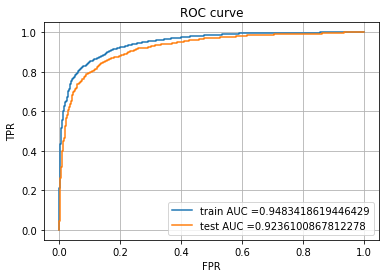

In [ ]:
# obtain AUC score
y_train_pred = sgd_clf.predict_proba(X_train)[:,1] # include proba for positive class only
y_test_pred = sgd_clf.predict_proba(X_test)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

Recall is 0.77
Precision is 0.91
F1-score is 0.83


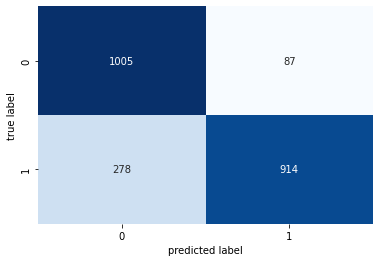

In [ ]:
y_pred = sgd_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_test, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

print('Recall is {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision is {:.2f}'.format(precision_score(y_test, y_pred)))
print('F1-score is {:.2f}'.format(f1_score(y_test, y_pred))) 

## 3. Text Sentiment Classification Using Embedding from TF-IDF

In [ ]:
# define custom function to remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]','',text)

In [ ]:
df1["review_wo_punct"] = df1["review"].map(remove_punctuation)
df1[['review','review_wo_punct']].head()

,review,review_wo_punct
0,"a stirring , funny and finally transporting re...",a stirring funny and finally transporting re ...
1,apparently reassembled from the cutting room f...,apparently reassembled from the cutting room f...
2,they presume their audience wo n't sit still f...,they presume their audience wo nt sit still fo...
3,this is a visually stunning rumination on love...,this is a visually stunning rumination on love...
4,jonathan parker 's bartleby should have been t...,jonathan parker s bartleby should have been th...


In [ ]:
y = df1['class']
X = df1['review_wo_punct']
X.head()

0    a stirring  funny and finally transporting re ...
1    apparently reassembled from the cutting room f...
2    they presume their audience wo nt sit still fo...
3    this is a visually stunning rumination on love...
4    jonathan parker s bartleby should have been th...
Name: review_wo_punct, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=2405)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4636,) (4636,)
(2284,) (2284,)


In [ ]:
from sklearn.feature_extraction import text
stop_words = list(text.ENGLISH_STOP_WORDS)
print(len(stop_words))
print(stop_words[:10])

318
['ten', 'found', 'whereupon', 'while', 'off', 'side', 'ever', 'latterly', 'hence', 'less']


In [ ]:
# perform TF-IDF vectorization of text data (review column): https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn
from sklearn.feature_extraction import text
stop_words = list(text.ENGLISH_STOP_WORDS)
tfidf_vectorizer = TfidfVectorizer(min_df=10, stop_words=stop_words, ngram_range=(1,4), max_features=2000)
tfidf_vectorizer.fit(X_train.values) # fit only on train data

# use the fitted TfidfVectorizer to convert the text to vector
X_train_tfidf = tfidf_vectorizer.transform(X_train.values)
X_test_tfidf = tfidf_vectorizer.transform(X_test.values)

print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

(4636, 780) (4636,)
(2284, 780) (2284,)


In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.9, ngram_range=(1,4), max_features=2000)
tfidf_vectorizer.fit(X_train.values) # fit only on train data

# use the fitted TfidfVectorizer to convert the text to vector
X_train_tfidf = tfidf_vectorizer.transform(X_train.values)
X_test_tfidf = tfidf_vectorizer.transform(X_test.values)

print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

(4636, 1440) (4636,)
(2284, 1440) (2284,)


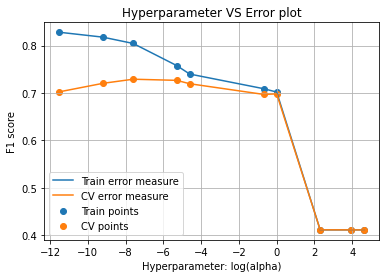

Best F1 score: 0.729
Best parameters:  {'alpha': 0.0005}
Best parameters (log transformed): -7.601


In [ ]:
# logistic regression hyperparameter tuning
log_reg = SGDClassifier(loss='log')
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
# parameters = {'alpha': np.linspace(0.0001, 100, 20)}

clf = RandomizedSearchCV(log_reg, parameters, scoring='f1', return_train_score=True, random_state=1989, error_score="raise") # default cv is 5, default n_iter is 10
clf.fit(X_train_tfidf, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_) #cv_results_ returns dict of metrics/details on Random Search CV
results = results.sort_values(['param_alpha'])
train_score = results['mean_train_score']
train_score_std = results['std_train_score']
cv_score = results['mean_test_score'] 
cv_score_std= results['std_test_score']
alpha =  results['param_alpha']

plt.plot(np.log(alpha.astype(float)), train_score, label='Train error measure')
plt.plot(np.log(alpha.astype(float)), cv_score, label='CV error measure')

plt.scatter(np.log(alpha.astype(float)), train_score, label='Train points')
plt.scatter(np.log(alpha.astype(float)), cv_score, label='CV points')

plt.legend()
plt.xlabel("Hyperparameter: log(alpha)")
plt.ylabel("F1 score")
plt.title("Hyperparameter VS Error plot")
plt.grid()
plt.show()
print("Best F1 score: {:.3f}".format(clf.best_score_))
print("Best parameters: ", clf.best_params_)
print("Best parameters (log transformed): {:.3f}".format(np.log(clf.best_params_['alpha'])))
# f1 score = 83% on alpha of 0.0005

In [ ]:
# train classifier using best hyperparameter
best_alpha = 0.0005
sgd_clf = SGDClassifier(loss='log', alpha=best_alpha, random_state=2405)
sgd_clf.fit(X_train_tfidf,y_train)

SGDClassifier(alpha=0.0005, loss='log', random_state=2405)

In [ ]:
sgd_clf.score(X_test_tfidf, y_test)

0.7066549912434326

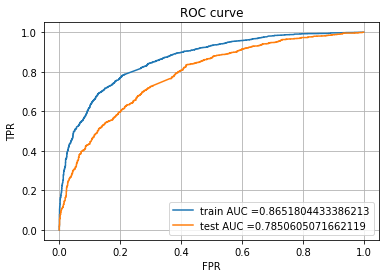

In [ ]:
y_train_pred = sgd_clf.predict_proba(X_train_tfidf)[:,1] # include proba for positive class only
y_test_pred = sgd_clf.predict_proba(X_test_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred) 
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC curve")
plt.grid()
plt.show()

Recall is 0.79
Precision is 0.69
F1-score is 0.74


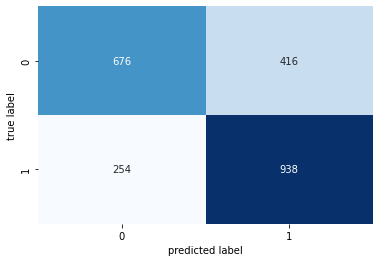

In [ ]:
y_pred = sgd_clf.predict(X_test_tfidf)
cm_test = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_test, cmap='Blues', annot=True, fmt='g', cbar=False)
plt.xlabel('predicted label')
plt.ylabel('true label');

print('Recall is {:.2f}'.format(recall_score(y_test, y_pred)))
print('Precision is {:.2f}'.format(precision_score(y_test, y_pred)))
print('F1-score is {:.2f}'.format(f1_score(y_test, y_pred))) 

>* Interestingly, the recall score of the classifier based on TF-IDF vectorization is slightly better than that of DistilBERT embedding.
>* However, the other performance metrics for the classifer based on DistilBERT are much better than that of TF-IDF vectorization.
>* As DistilBERT (which is a lighter version of BERT) provides contextualized embeddings for text, it is expected these embeddings will be very informative in labelling a movie review as having positive or negative sentiment. The stronger performance of the classifer based on DistilBERT reflects this.
>* However, the less sophisticated TF-IDF vectorization performs decently, proving that it is relatively robust.